# Loading & processing the projections data


Importing some essential packages.

In [ ]:
import os
import numpy as np
import pandas as pd

from scipy.spatial import distance as ds
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Loading NetworkX to perform the data manipulation on the graphs.

In [ ]:
import networkx as nx
from networkx.algorithms import tree
import community as community_louvain

Importing sklearn functions (clusters and evalaution tools)

In [ ]:
from sklearn.metrics import confusion_matrix, silhouette_score, silhouette_samples
from sklearn.cluster import SpectralClustering, AffinityPropagation, AgglomerativeClustering
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix
import itertools


The first step is to load the projections retrieved from the dimensionality reduction algorithms from "embedding_tutorial_&_umap_embedding.ipynb" notebook.
Then save the the projections and its lalels to csv files.



1.   train_embedding_1500 --> 1500 training data(TN_FN) --500 FN + 1000 TN
2.   train_embedding_label_1500 --> corresponding labels of 1500 training data
3.   test_embedding --> 1198 test data (30% of TN test image + 30% (109) FN test images
4.   test_embedding --> corresponding labels of test data
5.   train_embedding_image_names_3d_1500 --> original names of training images,it is necessary to filter out the images which falls inside cluster C (big and important one) for further analysis such as support vectors













In [ ]:
#read the 3d umap train projection csv file,their corresponding label and name of the original images
read_train_em=pd.read_csv("train_embedding_1500.csv")
read_train_lb=pd.read_csv("train_embedding_label_1500.csv")
read_train_image_name=pd.read_csv("train_embedding_image_names_3d_1500.csv")


In [ ]:
#convert the DataFrames to numpy array
projections=read_train_em.to_numpy(dtype=np.float32)
train_image_name=read_train_image_name.to_numpy()
lb=read_train_lb.to_numpy()
labels=[]
for i in lb:
  labels.append(i[0])
labels=np.array(labels)


# Get test sample projection points

In [ ]:
#read the 3d umap projection test csv file,their corresponding label and name of the original images
read_test_em=pd.read_csv("test_embedding.csv")
read_test_lb=pd.read_csv("test_embedding_label.csv")
# read_test_image_name=pd.read_csv("test_embedding_image_names_3d.csv")

In [ ]:
#read the 3d umap projection test csv file,their corresponding label and name of the original images
projections_test=read_test_em.to_numpy(dtype=np.float32)
lb_test=read_test_lb.to_numpy()
# read_test_image_name.to_numpy()
labels_test=[]
for i in lb_test:
  labels_test.append(i[0])
labels_test=np.array(labels_test)


# ALL the helper Functions 


### Seperate Clusters (good/mixed)

This is the function to separate all the clusters found using clustering/community detection algorithms into two categories 1) good cluster 2) mixed clusters using a threshold value. If the accuracy of the cluster is < threshold then its a mixed cluster or else good clusters.

In [ ]:
# seperate good and mixed clustrs [girvan_newman]
def good_mixed_cluster(node_groups,threshold,clusters_dict):
  good_q_cluster=dict()
  mixed_q_cluster=dict()
  c=0
  cluster_names=[]
  for i in clusters_dict:
    if clusters_dict[i]["percentage"]>=threshold:
      n_g = np.array(node_groups[i], dtype=np.int)
      # print (clusters_dict[i]["percentage"],clusters_dict[i]["label"],clusters_dict[i]["count"],len(n_g))
      good_cluster="good_cluster_"+str(clusters_dict[i]["label"])+str(i)+"_"+str(format(clusters_dict[i]["percentage"],'.2f'))+"%_"+"total_count"+str(len(n_g))
      name=str(clusters_dict[i]["label"])+str(i)
      cluster_names.append(name)
      good_q_cluster[good_cluster]=projections[n_g]

    else:
      n_g = np.array(node_groups[i], dtype=np.int)
      # print (clusters_dict[i]["percentage"],clusters_dict[i]["label"],clusters_dict[i]["count"],len(n_g))
      mixed_cluster="mixed_cluster_"+str(clusters_dict[i]["label"])+str(i)+"_"+str(format(clusters_dict[i]["percentage"],'.2f'))+"%_"+"total_count"+str(len(n_g))
      mixed_q_cluster[mixed_cluster]=projections[n_g]
      name=str(clusters_dict[i]["label"])+str(i)
      cluster_names.append(name)
   
  return good_q_cluster,mixed_q_cluster


### K nearest neighbour
This functions classify each test points to its nearest train points using KNN algorithm. k=1 and distance="ecuclidean" and give labels to the test point.

e.g- Let's say I have a test sample P and I know the ground truth of it (lets say FN) now I checked which train sample is closet to P, let's say Q (train sample), I already have the information that Q belongs to which cluster/domain lets say TN_cluster5 , that is how I can decide what should be the cluster/domain of the point P. So if Q belongs to a high-quality TN/FN or low quality TN/FN cluster then P  belongs to the same cluster (in this case TN_cluster5 ) as well and receives the label as TN.

In [ ]:
def calculate_k_nearest(projections,projections_test,labels_test,distance='euclidean'):
  nearest_neighbour=[]
  rows, cols = projections_test.shape[0],projections.shape[0]
  # matrix_shape = [rows, int(((rows * rows) - rows) / 2)]
  matrix = np.zeros(shape=(rows, cols))
  matrix.shape
  for i in range(rows):
    min=1000
    for j in range(cols):
       if distance == 'euclidean':
        matrix[i][j] = np.linalg.norm(projections_test[i] - projections[j])   
        if matrix[i][j]<min:
          min=matrix[i][j]
          index_train=j
          index_test=i
    # print (index_test,index_train,min)
    # print ("ok")
    nearest_neighbour.append([list(projections_test[index_test]),list(projections[index_train]),matrix[index_test][index_train],labels_test[index_test]])
  return nearest_neighbour

### Visualize the clusters in 2D 










In [ ]:
# # visualize the clusters detected by one of the clustering algorithm in 2D
# import plotly.graph_objects as go

# def Two_D_cluster(good_cluster,mixed_cluster):


#   l=[]
#   l1=[]

#   for item in good_cluster.items():
#     x=item[1][:,0]
#     y=item[1][:,1]


#     l.append([x,y,item[0]])

#   for item in mixed_cluster.items():
#     x1=item[1][:,0]
#     y1=item[1][:,1]
#     l1.append([x1,y1,item[0]])
  
#   fig = go.Figure()

  
#   # fig = plt.figure(figsize = (10, 7),dpi=200)
#   # ax = fig.add_subplot(111)

#   # ax.set_xlim(-2,6)
#   # ax.set_ylim(1,5)
#   # ax.set_zlim(2,3)
#   c=-1
#   c1=-1
#   unique_keys=good_cluster.keys()
#   col=["saddlebrown","g","r","magenta","purple","y","darkorange","deeppink"]
#   colors={}
#   for i in unique_keys:
#     c=c+1
#     colors[i]=col[c]


#   unique_keys_mixed=mixed_cluster.keys()
#   col1=["lime","slateblue","aqua","pink","black","tan","peru","bisque","teal","slategray","olive","crimson","greenyellow","deepskyblue"]
#   colors1={}
#   for i in unique_keys_mixed:
#     c1=c1+1
#     colors1[i]=col1[c1]
#   print (colors1)
#   for i in l:  
#     fig.scatter(i[0],i[1],label=i[2],s=22,color=colors[i[2]])
#     fig.legend(loc=2,fontsize=7)
#   for i in l1:  

#     fig.scatter(i[0],i[1],label=i[2],s=22,color=colors1[i[2]])
#     fig.legend(loc=2,fontsize=7)


In [ ]:
# # Visulize the main three clusters after we merge the clusters from clustering algo output in 2D
# #2D
# def Two_D_ABC_cluster(A,B,C): 
#     l=[]
#     l1=[]
#     l2=[]
    
#     x=A[:,0]
#     y=A[:,1]

#     l.append([x,y,"cluster_A"])
    
# #     ------------------------------------------------------

#     x1=B[:,0]
#     y1=B[:,1]
#     l1.append([x1,y1,"cluster_B"])
    
#     #     ------------------------------------------------------


#     x2=C[:,0]
#     y2=C[:,1]


#     l2.append([x2,y2,"cluster_C"])
#     #     ------------------------------------------------------

  
#     fig = plt.figure(figsize = (10, 7),dpi=200)
#     ax = fig.add_subplot(111)

#     for i in l:  
#       ax.scatter(i[0],i[1],label=i[2],s=22,color="green")
#       ax.legend(loc=2,fontsize=7)
#     for i in l1:  

#       ax.scatter(i[0],i[1],label=i[2],s=22,color="red")
#       ax.legend(loc=2,fontsize=7)
#     for i in l2:  

#       ax.scatter(i[0],i[1],label=i[2],s=22,color="blue")
#       ax.legend(loc=2,fontsize=7)


### Visualize the clusters in 3D

In [ ]:
# visualize the clusters detected by one of the clustering algorithm in 3D

def Three_D_cluster(good_cluster,mixed_cluster):


  l=[]
  l1=[]

  for item in good_cluster.items():
    x=item[1][:,0]
    y=item[1][:,1]
    z=item[1][:,2]


    l.append([x,y,z,item[0]])

  for item in mixed_cluster.items():
    x1=item[1][:,0]
    y1=item[1][:,1]
    z1=item[1][:,2]
    l1.append([x1,y1,z1,item[0]])
  
  
  fig = plt.figure(figsize = (10, 7),dpi=200)
  ax = fig.add_subplot(111,projection="3d")

  # ax.set_xlim(-2,6)
  # ax.set_ylim(1,5)
  # ax.set_zlim(2,3)
  c=-1
  c1=-1
  unique_keys=good_cluster.keys()
  col=["saddlebrown","g","r","magenta","purple","y","darkorange","deeppink"]
  colors={}
  for i in unique_keys:
    c=c+1
    colors[i]=col[c]


  unique_keys_mixed=mixed_cluster.keys()
  col1=["lime","slateblue","aqua","pink","black","tan","peru","bisque","teal","slategray","olive","crimson","greenyellow","deepskyblue"]
  colors1={}
  for i in unique_keys_mixed:
    c1=c1+1
    colors1[i]=col1[c1]
  print (colors1)
  for i in l:  
    ax.scatter(i[0],i[1],i[2],label=i[3],s=22,color=colors[i[3]])
    ax.legend(loc=2,fontsize=7)
  for i in l1:  
    print (colors1[i[3]])

    ax.scatter(i[0],i[1],i[2],label=i[3],s=22,color=colors1[i[3]])
    ax.legend(loc=2,fontsize=7)


In [ ]:
# Visulize the main three clusters after we merge the clusters from clustering algo output in 3D
#3d
def Three_D_ABC_cluster(A,B,C):


  
    l=[]
    l1=[]
    l2=[]
    
    x=A[:,0]
    y=A[:,1]
    z=A[:,2]

    l.append([x,y,z,"cluster_A"])
    
#     ------------------------------------------------------

    x1=B[:,0]
    y1=B[:,1]
    z1=B[:,2]
    l1.append([x1,y1,z1,"cluster_B"])
    
    #     ------------------------------------------------------


    x2=C[:,0]
    y2=C[:,1]
    z2=C[:,2]


    l2.append([x2,y2,z2,"cluster_C"])
    #     ------------------------------------------------------

  
    fig = plt.figure(figsize = (10, 7),dpi=200)
    ax = fig.add_subplot(111,projection="3d")

    for i in l:  
      ax.scatter(i[0],i[1],i[2],label=i[3],s=22,color="green")
      ax.legend(loc=2,fontsize=7)
    for i in l1:  

      ax.scatter(i[0],i[1],i[2],label=i[3],s=22,color="red")
      ax.legend(loc=2,fontsize=7)
    for i in l2:  

      ax.scatter(i[0],i[1],i[2],label=i[3],s=22,color="blue")
      ax.legend(loc=2,fontsize=7)


# Constructing the distance matrix, then normalize it and use it to construct the graph.

**Cosine distance**

In [ ]:
print ((projections[1]))

[14.298074   9.777908   7.2523456]


In [ ]:
(1)- np.dot(projections[1], projections[1])/(np.linalg.norm(projections[1]) * np.linalg.norm(projections[1]))

0.0

In [ ]:
print (projections[1])

[14.298074   9.777908   7.2523456]


In [ ]:
projections[1]

array([14.298074 ,  9.777908 ,  7.2523456], dtype=float32)

**Euclidean distance**

In [ ]:
np.linalg.norm(projections[1][:3] - projections[1][:3])

0.0

In [ ]:
def calculate_distance_matrix(projections, num_dimensions = 2, distance='euclidean'):
  rows, cols = projections.shape
  matrix_shape = [rows, int(((rows * rows) - rows) / 2)]
  matrix = np.zeros(shape=(rows, rows))
  min = 100
  for i in range(rows):
    for j in range(rows):
      if distance == 'euclidean':
        matrix[i][j] = np.linalg.norm(projections[i][:num_dimensions] - projections[j][:num_dimensions])
      elif distance == 'cosine':
        matrix[i][j] = np.dot(projections[i], projections[j])/(np.linalg.norm(projections[i]) * np.linalg.norm(projections[j]))
      if 0 < matrix[i][j] < min :
        min = matrix[i][j]
  return matrix, min

In [ ]:
distance = 'euclidean'
matrix, second_min = calculate_distance_matrix(projections,num_dimensions=3,distance=distance)
print (matrix)
print("Matrix shape: ", matrix.shape)
print (type(matrix))
print (matrix.ndim)
second_min

[[0.         1.30398202 1.45620871 ... 5.44994736 5.32390404 4.79786158]
 [1.30398202 0.         2.66116428 ... 5.53370142 5.47891712 4.58278847]
 [1.45620871 2.66116428 0.         ... 5.09317255 4.91385603 4.8176055 ]
 ...
 [5.44994736 5.53370142 5.09317255 ... 0.         0.35321984 1.42151189]
 [5.32390404 5.47891712 4.91385603 ... 0.35321984 0.         1.59933841]
 [4.79786158 4.58278847 4.8176055  ... 1.42151189 1.59933841 0.        ]]
Matrix shape:  (1500, 1500)
<class 'numpy.ndarray'>
2


0.011782744899392128

The matrix should be symmetric and the main diagonal should be zeros.

In [ ]:
print(matrix[10][20])
print(matrix[20][10])
print(matrix[120][120])
print(matrix.min())
print(matrix.max())

2.518407106399536
2.518407106399536
0.0
0.0
9.00699234008789


In [ ]:
# print("First element in the matrix: \n", np.array(matrix[0]))

We only need to normalize for the Euclidean distance. using min-max normalization

In [ ]:
print("Maximum value/weight in the matrix: ", matrix.max())
print("Minimum value/weight in the matrix: ", matrix.min())
if distance == 'euclidean':
  matrix = (matrix - matrix.min()) / (matrix.max() - matrix.min())
  print("Maximum value/weight in the matrix (after normalization): ", matrix.max())
  print("Minimum value/weight in the matrix (after normalization): ", matrix.min())

Maximum value/weight in the matrix:  9.00699234008789
Minimum value/weight in the matrix:  0.0
Maximum value/weight in the matrix (after normalization):  1.0
Minimum value/weight in the matrix (after normalization):  0.0


Convert the normalized distance matrix into the similarity matrix.

In [ ]:
 normalized_similarity_matrix = 1 - matrix

In [ ]:
print (normalized_similarity_matrix)

[[1.         0.85522559 0.83832464 ... 0.3949204  0.40891434 0.46731812]
 [0.85522559 1.         0.70454463 ... 0.38562161 0.39170403 0.49119658]
 [0.83832464 0.70454463 1.         ... 0.43453127 0.45443986 0.46512606]
 ...
 [0.3949204  0.38562161 0.43453127 ... 1.         0.96078382 0.84217685]
 [0.40891434 0.39170403 0.45443986 ... 0.96078382 1.         0.82243369]
 [0.46731812 0.49119658 0.46512606 ... 0.84217685 0.82243369 1.        ]]


In [ ]:
graph = nx.from_numpy_array(normalized_similarity_matrix)

In [ ]:
# normalized_similarity_matrix.shape

# Calculating the spanning tree

For the distance matrix, we need to calculate the minimum spanning tree because we want to find the edges with the minimum distance between them, on the other hand for the similarity matrix we need to calculate the maximum spanning tree because we want to find the edges with the maximum similarity between them.

In [ ]:
mst =tree.maximum_spanning_edges(graph, algorithm='kruskal') # algorithm='prim'
maximum_edgelist = list(mst)
print(maximum_edgelist)
print(len(maximum_edgelist))

[(691, 919, {'weight': 0.9986918224803023}), (768, 786, {'weight': 0.9981388699371943}), (610, 614, {'weight': 0.9978293539688138}), (692, 1081, {'weight': 0.9978031338090141}), (1236, 1259, {'weight': 0.9977752185104033}), (127, 251, {'weight': 0.9977601401090194}), (67, 380, {'weight': 0.9977589175079883}), (384, 434, {'weight': 0.9976441706521806}), (204, 904, {'weight': 0.9976288277537197}), (1247, 1433, {'weight': 0.9975027476427855}), (380, 381, {'weight': 0.997435691739987}), (67, 306, {'weight': 0.9974138898601316}), (47, 238, {'weight': 0.9970880910877276}), (1254, 1360, {'weight': 0.9970820452925406}), (573, 1167, {'weight': 0.9970816486503252}), (221, 1197, {'weight': 0.997040297768766}), (558, 676, {'weight': 0.9970125760348652}), (307, 401, {'weight': 0.9969980942512036}), (19, 1032, {'weight': 0.996907808515214}), (110, 1348, {'weight': 0.9968690465616502}), (1465, 1485, {'weight': 0.9968042561517975}), (33, 703, {'weight': 0.9967152742892013}), (1265, 1361, {'weight': 0.

Sample from the leftover edges 
and keep a percentange of them.

In [ ]:
str_edgelist = []
str_edgelist = [f"{str(edge[0])} {str(edge[1])} {str(edge[2])}" for edge in maximum_edgelist]
str_edgelist
complete_edgelist = list(graph.edges(data=True))
fraction_to_keep = 0.001 # @param {type: 'number'}
number_of_edges_to_keep = int(fraction_to_keep * len(complete_edgelist))

In [ ]:
number_of_edges_to_keep

1125

In [ ]:
sorted_weight_index_edgelist = sorted([[e[2]['weight'], i] for i,e in enumerate(complete_edgelist)], reverse=True)

for i in range(len(projections), len(sorted_weight_index_edgelist)):
  if number_of_edges_to_keep <= 0:
    break
  _, index = sorted_weight_index_edgelist[i]
  if complete_edgelist[index] not in maximum_edgelist:
     str_edgelist.append(f"{str(complete_edgelist[index][0])} {str(complete_edgelist[index][1])} {str(complete_edgelist[index][2])}")
     number_of_edges_to_keep -= 1  

In [ ]:
#  (str_edgelist[:])

In [ ]:
print("Number of edges in the new graph:", len( str_edgelist))

Number of edges in the new graph: 2624


In [ ]:
print (projections[36],projections[175])

[11.826657 12.396599  6.82918 ] [12.324412 11.086231  7.713012]


In [ ]:
np.linalg.norm(projections[36]-projections[175])


1.6571008

In [ ]:
matrix[36][175]

0.1839793722621678

#Evaluation Metrics

## Assign labels to clusters based on the ground truth


---


Assign a label to each cluster according to it's most repeated class, helpful for the evaluation unless there are a lot of clusters.<br>
**It needs the ground truth labels**.

In [ ]:
def get_cluster_max_labels(node_groups):
  clusters_dict = {}
  clusters_count =  0

  # Count the labels in each cluster
  for i in node_groups:
    cluster = labels[np.array(i, dtype=np.int)]
    labels_dict = {}
    for j in cluster:
      if j not in labels_dict:
        labels_dict[j] = 1
      else:
        labels_dict[j] += 1 
    # print(labels_dict)


    total_cluster_count = 0
    max_value = 0
    max_percentage = 0
    max_label = ""

    for label in np.unique(labels):
      if label in labels_dict:
        total_cluster_count += labels_dict[label]
        if labels_dict[label] > max_value:
          max_value = labels_dict[label]
          max_label = label
    max_percentage = max_value / total_cluster_count
    # print(max_percentage, max_value, max_label)

    if max_percentage >= 0.5:
      # the cluster belongs to this type
      clusters_dict[clusters_count] = {"label" : max_label, "percentage" : max_percentage, "count" : max_value}
      clusters_count +=1
  print("Clusters information: ", clusters_dict)

  TORF = []
  points = []
  predicted_lables = []
  point_group = []
  for i in range(len(node_groups)):
    current_cluster_label = clusters_dict[i]['label']
    for j in node_groups[i]:
      point_group.append(i)
      points.append(int(j))
      predicted_lables.append(current_cluster_label)
      if labels[int(j)] == current_cluster_label:
        TORF.append(1)
      else:
        TORF.append(0)
        
  # could be seen as precision (if there are too many clusters than it's safe to assume that this number should be high, if not then there is no to little structure in the projections)
  print("Estimated accuracy: ",np.sum(TORF) / len(TORF))
  return points, predicted_lables, point_group,clusters_dict

## Plotting the confusion matrix 

---
**It needs ground truth labels**

In [ ]:
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = confusion_matrix(np.array(y_test), np.array(y_pred))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# First Method: Community Detection

In [ ]:
mst_graph = nx.parse_edgelist(str_edgelist)

Draw a graph of the entire dataset, could be a bit slow.

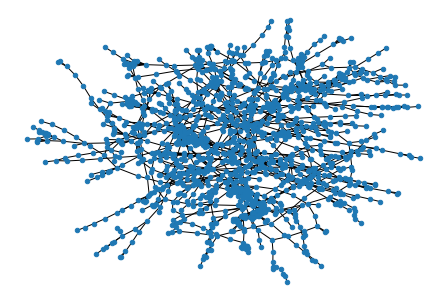

In [ ]:
G = mst_graph
nx.draw(G, with_labels=False, node_size=20)

# 2) Louvain community detection algorithm

Multiple runs are required for a good estimate, because of the random factor in the method.

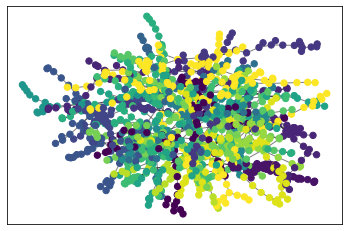

Number of clusters found:  20
Number of points clustred:  1500


In [ ]:
G = mst_graph
Louvain_resolution= 6 #@param {type:"slider", min:1, max:100, step:1}
partition = community_louvain.best_partition(G,resolution=6,random_state=40)
# ,resolution

pos = nx.spring_layout(G)
cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()
print("Number of clusters found: ", np.unique(np.array(list(partition.values()))).shape[0])
print("Number of points clustred: ", np.unique(np.array(list(partition.keys()))).shape[0])

In [ ]:
Louvain_clusters = np.empty(np.unique(np.array(list(partition.values()))).shape,dtype=object)
for key, value in partition.items():
  tmp_a = Louvain_clusters[value]
  if tmp_a is None:
    tmp_a = []
  tmp_a.append(key)
  Louvain_clusters[value] = tmp_a
print(len(Louvain_clusters[0]))

87


In [ ]:
Louvain_points, Louvain_predicted_lables, Louvain_group ,cluster_dict= get_cluster_max_labels(Louvain_clusters)

Clusters information:  {0: {'label': 'TN', 'percentage': 0.9540229885057471, 'count': 83}, 1: {'label': 'TN', 'percentage': 1.0, 'count': 66}, 2: {'label': 'TN', 'percentage': 0.6153846153846154, 'count': 48}, 3: {'label': 'TN', 'percentage': 0.84, 'count': 63}, 4: {'label': 'TN', 'percentage': 0.8055555555555556, 'count': 58}, 5: {'label': 'FN', 'percentage': 0.9135802469135802, 'count': 74}, 6: {'label': 'FN', 'percentage': 0.9629629629629629, 'count': 26}, 7: {'label': 'FN', 'percentage': 0.7735849056603774, 'count': 41}, 8: {'label': 'TN', 'percentage': 0.9705882352941176, 'count': 66}, 9: {'label': 'FN', 'percentage': 0.5686274509803921, 'count': 29}, 10: {'label': 'TN', 'percentage': 0.7857142857142857, 'count': 22}, 11: {'label': 'TN', 'percentage': 0.6705882352941176, 'count': 57}, 12: {'label': 'TN', 'percentage': 0.5909090909090909, 'count': 52}, 13: {'label': 'TN', 'percentage': 0.9117647058823529, 'count': 93}, 14: {'label': 'FN', 'percentage': 0.5571428571428572, 'count': 

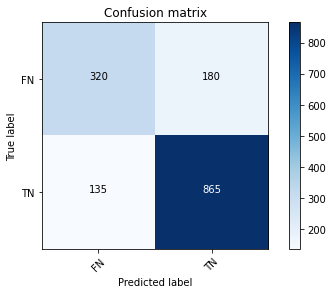

In [ ]:
plot_confusion_matrix(labels[Louvain_points], Louvain_predicted_lables, np.unique(labels))

# Once we have clustering information use them for further processing such as seperate the clusters into bad and good clusters

In [ ]:
# seperate the good and mixed clusters (thresold>=90 is good otherwise mixed)
good_cluster,mixed_cluster=good_mixed_cluster(Louvain_clusters,0.90,cluster_dict)


In [ ]:
list(mixed_cluster)

['mixed_cluster_TN2_0.62%_total_count78',
 'mixed_cluster_TN3_0.84%_total_count75',
 'mixed_cluster_TN4_0.81%_total_count72',
 'mixed_cluster_FN7_0.77%_total_count53',
 'mixed_cluster_FN9_0.57%_total_count51',
 'mixed_cluster_TN10_0.79%_total_count28',
 'mixed_cluster_TN11_0.67%_total_count85',
 'mixed_cluster_TN12_0.59%_total_count88',
 'mixed_cluster_FN14_0.56%_total_count70',
 'mixed_cluster_FN15_0.67%_total_count89',
 'mixed_cluster_TN17_0.74%_total_count62',
 'mixed_cluster_FN18_0.61%_total_count84',
 'mixed_cluster_TN19_0.85%_total_count158']

In [ ]:
list(good_cluster)

['good_cluster_TN0_0.95%_total_count87',
 'good_cluster_TN1_1.00%_total_count66',
 'good_cluster_FN5_0.91%_total_count81',
 'good_cluster_FN6_0.96%_total_count27',
 'good_cluster_TN8_0.97%_total_count68',
 'good_cluster_TN13_0.91%_total_count102',
 'good_cluster_TN16_1.00%_total_count76']

{'mixed_cluster_TN2_0.62%_total_count78': 'lime', 'mixed_cluster_TN3_0.84%_total_count75': 'slateblue', 'mixed_cluster_TN4_0.81%_total_count72': 'aqua', 'mixed_cluster_FN7_0.77%_total_count53': 'pink', 'mixed_cluster_FN9_0.57%_total_count51': 'black', 'mixed_cluster_TN10_0.79%_total_count28': 'tan', 'mixed_cluster_TN11_0.67%_total_count85': 'peru', 'mixed_cluster_TN12_0.59%_total_count88': 'bisque', 'mixed_cluster_FN14_0.56%_total_count70': 'teal', 'mixed_cluster_FN15_0.67%_total_count89': 'slategray', 'mixed_cluster_TN17_0.74%_total_count62': 'olive', 'mixed_cluster_FN18_0.61%_total_count84': 'crimson', 'mixed_cluster_TN19_0.85%_total_count158': 'greenyellow'}
lime
slateblue
aqua
pink
black
tan
peru
bisque
teal
slategray
olive
crimson
greenyellow


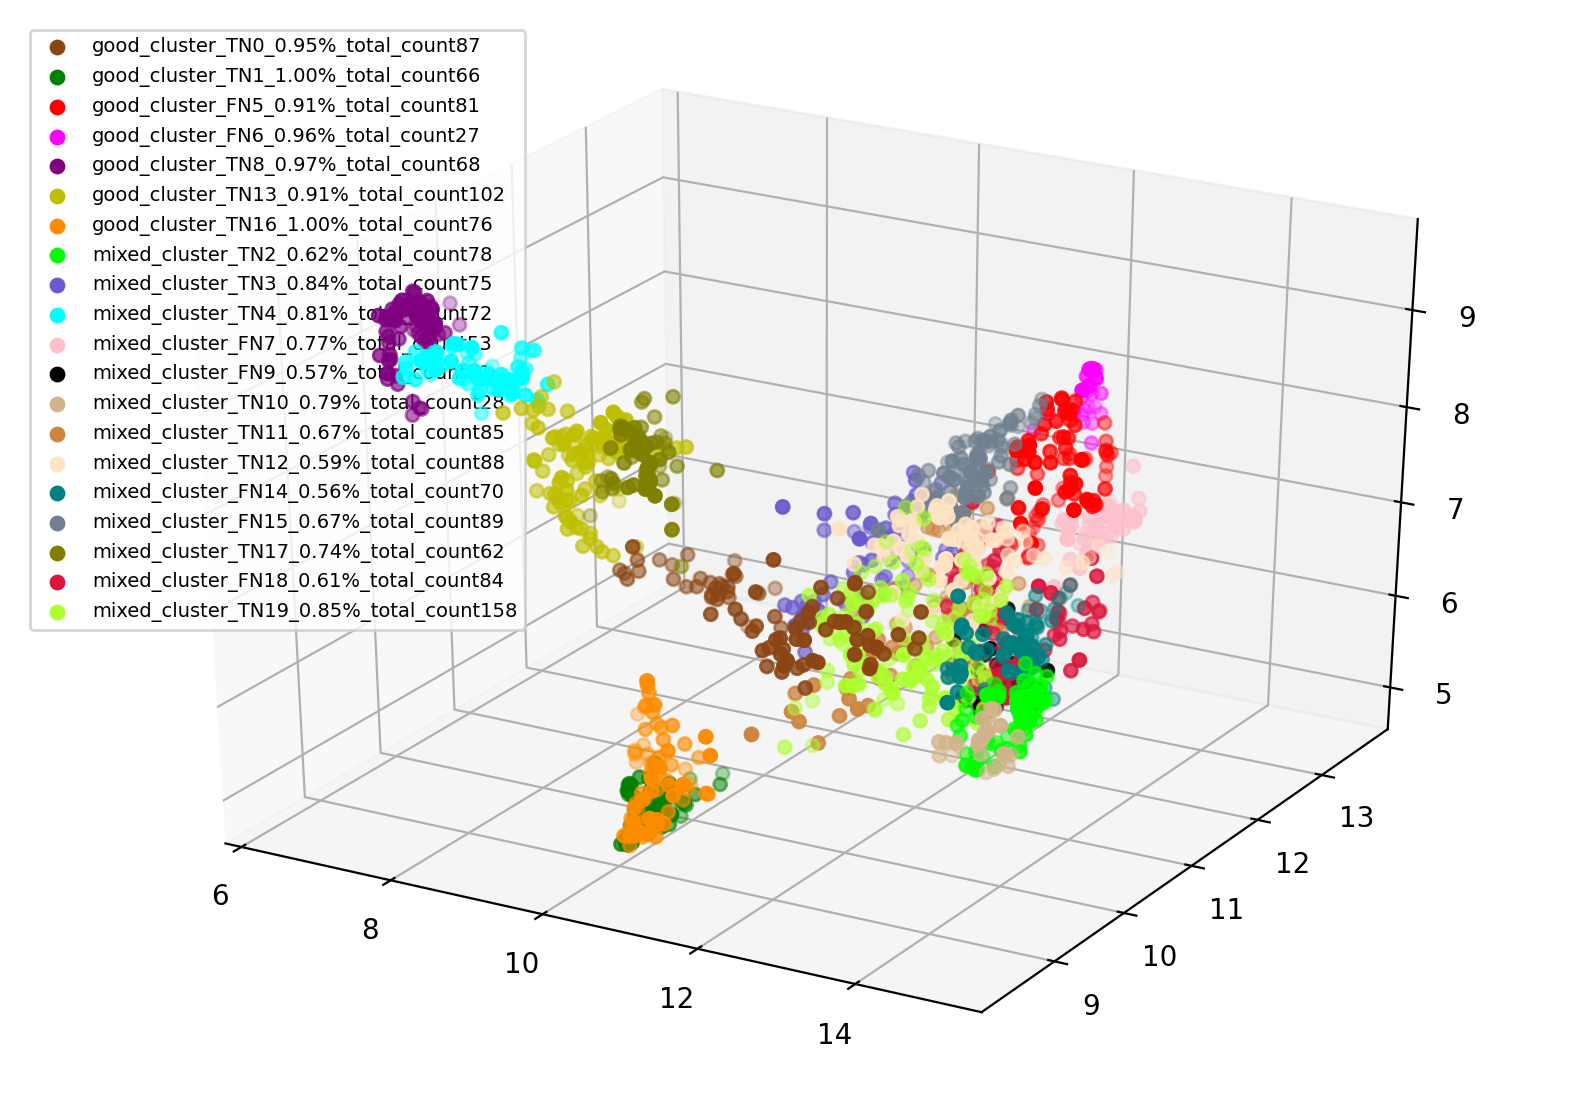

In [ ]:
#plot all the detected clusters by the alogorithm in 3D
Three_D_cluster(good_cluster,mixed_cluster)

# Merge all the clusters (good and mixed) as we will need all the clusters to get back the 3 main clusters (A,B,C)

HOW?----- check the original umap graph and compare that with the cluster grapgh  and decide.This is where we are combining the humnan knowledge and graph algorithm outputs.

In [ ]:
def Merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res
       
# Driver code
merged_good_bad = Merge(good_cluster,mixed_cluster)


# 3D section

seperate the points from train embeddings into cluster A,B,C

In [ ]:
#cluster A=TN16+TN1
#cluster B=TN8+TN4+TN13+mixedTN
#cluster C=rest
 
A=[]
A_label=[]

B=[]
B_label=[]

C=[]
C_label=[]


for i in merged_good_bad.items():
    lb=[]
  
  
    if i[0]=="good_cluster_TN16_1.00%_total_count76" or i[0]=="good_cluster_TN1_1.00%_total_count66":
      l=i[0].split("_")[2][0:2]

      A.append(i[1])
      lb=len(i[1]) * [l]
      A_label.append(lb)




    elif i[0]=="good_cluster_TN8_0.97%_total_count68" or i[0]=="mixed_cluster_TN4_0.81%_total_count72" or i[0]=="good_cluster_TN13_0.91%_total_count102" or i[0]=="mixed_cluster_TN17_0.74%_total_count62":
      l=i[0].split("_")[2][0:2]

      B.append(i[1])
      lb=len(i[1]) * [l]
      B_label.append(lb)
    else:
      l=i[0].split("_")[2][0:2]

      C.append(i[1])
      lb=len(i[1]) * [l]
      C_label.append(lb)
    
 

In [ ]:
#concate points of A clustes
A=np.concatenate((A[0],A[1]))

In [ ]:
#concate points of B clustes

B=np.concatenate((B[0],B[1],B[2],B[3]))

In [ ]:
#concate points of C clustes

C=np.concatenate((C[0],C[1],C[2],C[3],C[4],C[5],C[6],C[7],C[8],C[9],C[10],C[11],C[12],C[13]))


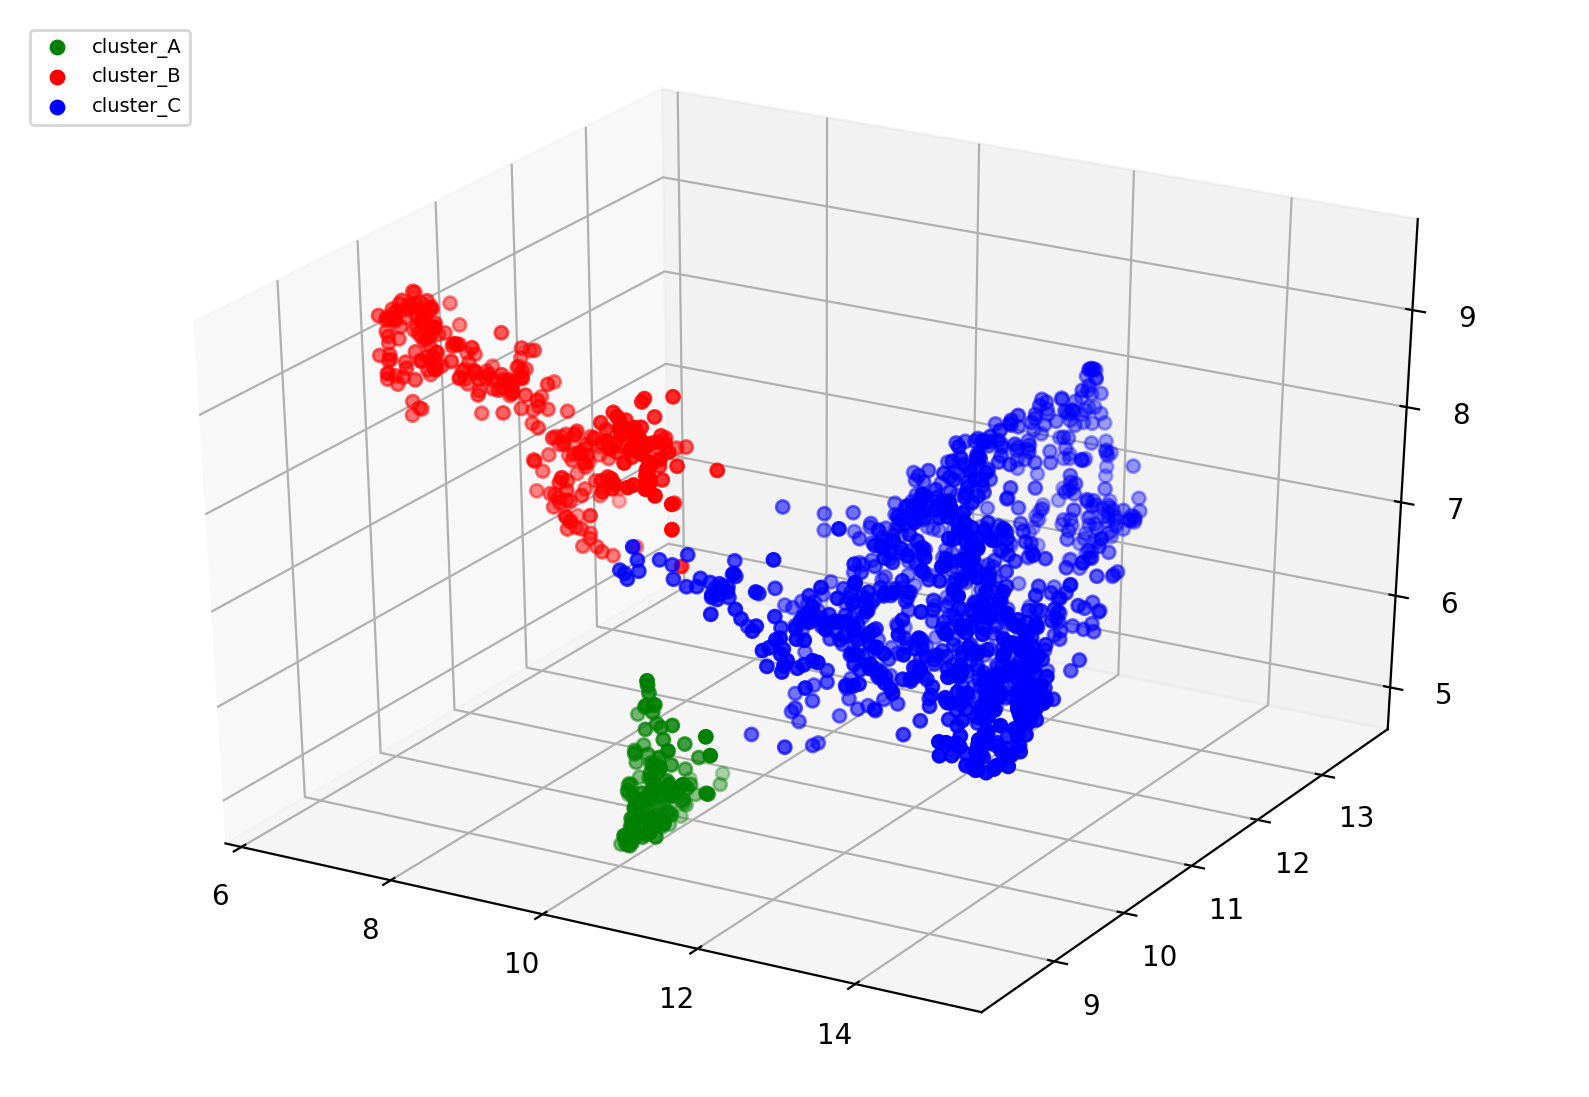

In [ ]:
#visualize the main three clusters after mergering
Three_D_ABC_cluster(A,B,C)

# Classify 1298 test samples among cluster A,B,C

In [ ]:
test_p_A=[]
pred_test_p_A=[]

test_p_B=[]
pred_test_p_B=[]

test_p_C=[]
pred_test_p_C=[]


def classify_test_samples(A,B,C,nearest_neighbour):


  for i in nearest_neighbour:
    if i[1] in A:
      test_p_A.append(i[0])
      # if i[3]=="TN":
      #   pred_test_p_A.append("TTN")
      # else:
      pred_test_p_A.append(i[3])
  #-----------------------------------------------------
    if i[1] in B:
      test_p_B.append(i[0])
      # if i[3]=="TN":
      #   pred_test_p_B.append("TTN")
      # else:
      pred_test_p_B.append(i[3])

  #------------------------------------------------------------
    if i[1] in C:
      test_p_C.append(i[0])
      pred_test_p_C.append(i[3])

  
  return test_p_A,pred_test_p_A,test_p_B,pred_test_p_B,test_p_C,pred_test_p_C

nearest_neighbour=calculate_k_nearest(projections,projections_test,labels_test,distance='euclidean')

test_p_A,pred_test_p_A,test_p_B,pred_test_p_B,test_p_C,pred_test_p_C=classify_test_samples(A,B,C,nearest_neighbour)
  





 
      
      
    

In [ ]:
# check how many test samples (TN and FN) falling inside cluster A,B,C
print ("len of A(TN_cluster):",len(test_p_A),"TN:",pred_test_p_A.count("TN"),"FN:",pred_test_p_A.count("FN"))
print ("len of B(TN_cluster):",len(test_p_B),"TN:",pred_test_p_B.count("TN"),"FN:",pred_test_p_B.count("FN"))
print ("len of C(FN_cluster + TN_cluster):",len(test_p_C),"TN:",pred_test_p_C.count("TN"),"FN:",pred_test_p_C.count("FN"))


len of A(TN_cluster): 105 TN: 105 FN: 0
len of B(TN_cluster): 245 TN: 221 FN: 24
len of C(FN_cluster + TN_cluster): 948 TN: 863 FN: 85


In [ ]:
# len(test_p_B_balanced)

In [ ]:
# # make a balanced set of test data which fall inside B cluster
# pred_test_p_B_balanced=[]
# test_p_B_balanced=[]

# for i in range(len(pred_test_p_B)):
#   if pred_test_p_B[i]=="FN":
#     test_p_B_balanced.append(test_p_B[i])
#     pred_test_p_B_balanced.append(pred_test_p_B[i])
# c=0
# for i in range(len(pred_test_p_B)):
#   if pred_test_p_B[i]=="TN":
#     test_p_B_balanced.append(test_p_B[i])
#     pred_test_p_B_balanced.append(pred_test_p_B[i])

#     c=c+1
#     if c==30:
#       break
    


# Once we have cluster A,B,C,use those clusters for further classification using SVC ISIC2019.

 A (high quality TN), B (mixed--effected by the scales) and C (mixed) 

It is not neccessary to train an SVM for A cluster.

*   train an SVM on only the B cluster’s samples (train-B) --> call it SVM-B
*  train an SVM on only the C cluster’s samples (train-C) --> call it SVM-C







In [ ]:

#pre data processing for svc, scale the embeddings and covert the labels into binary
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
ord_enc = OrdinalEncoder()

from sklearn import preprocessing

def pre_process(X_train,Y_train,X_test,Y_test):

  scaler = preprocessing.StandardScaler().fit(X_train)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)
  
  label_encoder = LabelEncoder()
  Y_train= label_encoder.fit_transform(Y_train)
  Y_test= label_encoder.fit_transform(Y_test)

  return X_train,X_test,Y_train,Y_test

In [ ]:
#get the labels of cluster B and C each point
# #prepare data for SVC
# x_train_A=[]
# y_train_A=[]

x_train_B=[]
y_train_B=[]

x_train_B_balanced=[]
y_train_B_balanced=[]

x_train_C=[]
y_train_C=[]
projections_list=projections.tolist()

# #SVC_B cluster
B1=B.tolist()
for i in B1:
  if i in projections_list:
    idx=projections_list.index(i)
    x_train_B.append(i)
    y_train_B.append(labels[idx])

# #SVC_B cluster balanced data
# image_names_train_B=[]

B1_balanced=B.tolist()
import random
# random.shuffle(B1_balanced)
# c=0
# for i in B1_balanced:
#   if i in projections_list:
#     idx=projections_list.index(i)
#     if labels[idx]=="TN":
#       x_train_B_balanced.append(i)
#       y_train_B_balanced.append(labels[idx])
#       # image_names_train_B.append(train_image_name[idx])
#       c=c+1
#       if c==50:
#         break

# for i in B1_balanced:
#   if i in projections_list:
#     idx=projections_list.index(i)
#     if labels[idx]=="FN":
#       x_train_B_balanced.append(i)
#       y_train_B_balanced.append(labels[idx])

# # #SVC_C cluster
image_names_train_C=[]
C1=C.tolist()
for i in C1:
  if i in projections_list:
    idx=projections_list.index(i)
    x_train_C.append(i)
    y_train_C.append(labels[idx])
    image_names_train_C.append(train_image_name[idx].tolist()[0])



In [ ]:
# pd.DataFrame(image_names_train_C).to_csv("images_names_cluster_C_isic2019.csv")


In [ ]:
# handling data imbalanced technique -- not used 
# from imblearn.under_sampling import TomekLinks
# from collections import Counter
# # tl = RandomOverSampler(sampling_strategy='majority')
# tl = TomekLinks()
# x_C, y_C = tl.fit_sample(x_train_C,y_train_C)

# print('Resampled dataset shape {}'.format(Counter(y_C)))

In [ ]:
len(x_train_C),len(y_train_C)
y_train_C.count("TN")

595

In [ ]:
x_train_B,x_test_B,y_train_B,y_test_B=pre_process(x_train_B,y_train_B,test_p_B,pred_test_p_B)

In [ ]:
x_train_C,x_test_C,y_train_C,y_test_C=pre_process(x_train_C,y_train_C,test_p_C,pred_test_p_C)

In [ ]:
# x_train_B_balanced,x_test_B_balanced,y_train_B_balanced,y_test_B_balanced=pre_process(x_train_B_balanced,y_train_B_balanced,test_p_B_balanced,pred_test_p_B_balanced)

# SVC experiment

In [ ]:
# grid search function which will be used to decide which parameters to use for final model
def SVC_gridcv_search(X,Y):
  # define model
  model = SVC()
  # define grid
  # balance = [{0:100,1:1},{0:5,1:2},{0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
  param_grid = {'C':[10**-5, 10**-4, 10**-2, 10**-3, 10**-2,10**-1,10,10**0,10**2,10**3,10**4], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  # define grid search
  grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
  # execute the grid search
  grid_result = grid.fit(X, Y)
  # report the best configuration
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  # report all configurations
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
      print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
#After deciding upon the parameters from "SVC_gridcv_search" function used them to get the final model
def final_model_svc(C,gamma,X,Y,weights,kernel):
 
  model = SVC(C=C,gamma=gamma,kernel=kernel,class_weight=weights,decision_function_shape='ovo',probability=True)
  model.fit(X,Y)
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  # evaluate model
  scores = cross_val_score(model,X ,Y , scoring='roc_auc', cv=cv, n_jobs=-1)
  print (scores)
  # summarize performance
  print('Mean ROC AUC: %.3f' % mean(scores))
  return model

In [ ]:
#plot the output of SVM
def plot_svm_output(X_train,prediction,model):
  TN_class=[]
  FN_class=[]
  support_vector_indices = model.support_
  support_vectors_per_class = model.n_support_
  support_vectors = model.support_vectors_
  print (len(support_vector_indices))

  
  for i in range(len(prediction)):
    
    if prediction[i]==1:
      TN_class.append(X_train[i])
    else:
      FN_class.append(X_train[i])
  TN_class=np.array(TN_class)
  FN_class=np.array(FN_class)

  fig = plt.figure(figsize = (10, 7),dpi=200)
  ax = fig.add_subplot(111,projection='3d')


  ax.scatter(TN_class[:,0],TN_class[:,1],TN_class[:,2],label="TN",s=30,color="Deeppink")
  ax.legend(loc=2,fontsize=7)
  ax.scatter(FN_class[:,0],FN_class[:,1],FN_class[:,2],label="FN",s=30,color="yellow")
  ax.legend(loc=2,fontsize=7)

  ax.scatter(support_vectors[:,0], support_vectors[:,1],support_vectors[:,2],s=2,marker="*",color="black")
  ax.legend(loc=2,fontsize=7)


# Original Umap -- of training embedding ---> you can also find out the same umap in the embedding tutorial

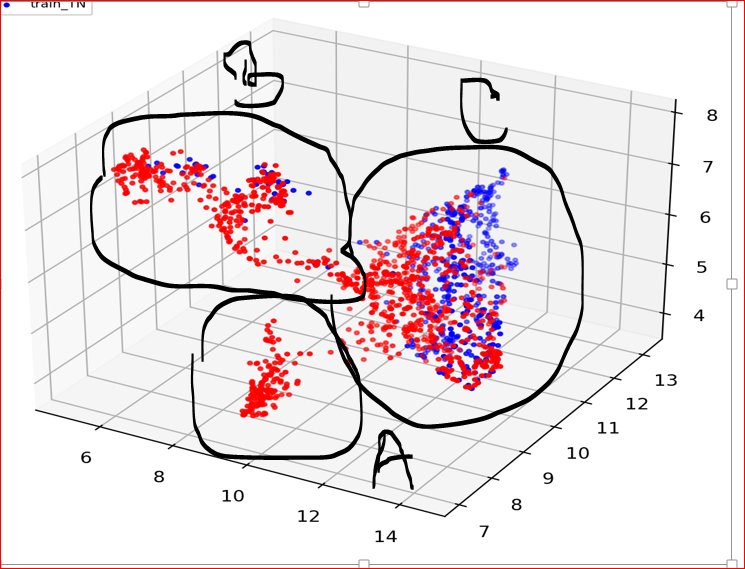

# SECTION CLUSTER *B*



####  train an SVM on imbalanced the B cluster’s samples (train-B) --> call it SVM-B


In [ ]:
SVC_gridcv_search(x_train_B,y_train_B)

Best: 0.757877 using {'C': 10000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.597104 (0.139580) with: {'C': 1e-05, 'gamma': 1, 'kernel': 'rbf'}
0.683065 (0.151384) with: {'C': 1e-05, 'gamma': 0.1, 'kernel': 'rbf'}
0.646925 (0.131529) with: {'C': 1e-05, 'gamma': 0.01, 'kernel': 'rbf'}
0.645354 (0.137095) with: {'C': 1e-05, 'gamma': 0.001, 'kernel': 'rbf'}
0.643559 (0.137193) with: {'C': 1e-05, 'gamma': 0.0001, 'kernel': 'rbf'}
0.597104 (0.139580) with: {'C': 0.0001, 'gamma': 1, 'kernel': 'rbf'}
0.683065 (0.151384) with: {'C': 0.0001, 'gamma': 0.1, 'kernel': 'rbf'}
0.646925 (0.131529) with: {'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}
0.645354 (0.137095) with: {'C': 0.0001, 'gamma': 0.001, 'kernel': 'rbf'}
0.643559 (0.137193) with: {'C': 0.0001, 'gamma': 0.0001, 'kernel': 'rbf'}
0.690076 (0.125375) with: {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}
0.556061 (0.162422) with: {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
0.664098 (0.135161) with: {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
0.645354 (0.1

In [ ]:
#output for B cluster imbalanced
from sklearn import metrics
#final parameters C=10 , gamma=0.1
weights ={0:6.5,1:1}
model=final_model_svc(10,0.1,x_train_B,y_train_B,weights,"rbf")
output=model.predict(x_train_B)
output1=model.predict(x_test_B)

print (metrics.balanced_accuracy_score(y_train_B,output))
print (metrics.balanced_accuracy_score(y_test_B,output1))




# plot_confusion_matrix(y_train_B,output,list(set(y_train_B))) 


[0.5462963  0.84259259 0.90740741 0.96153846 0.78846154 0.81730769
 0.77884615 0.75       0.58653846 0.73076923 0.87962963 0.77777778
 0.93518519 0.54615385 0.94230769 0.86538462 0.45192308 0.69230769
 0.80769231 0.82692308 0.61111111 0.88888889 0.76851852 0.73076923
 0.92307692 0.73076923 0.85576923 0.75961538 0.96153846 0.55769231]
Mean ROC AUC: 0.774
0.7845683019567838
0.6541289592760181


178


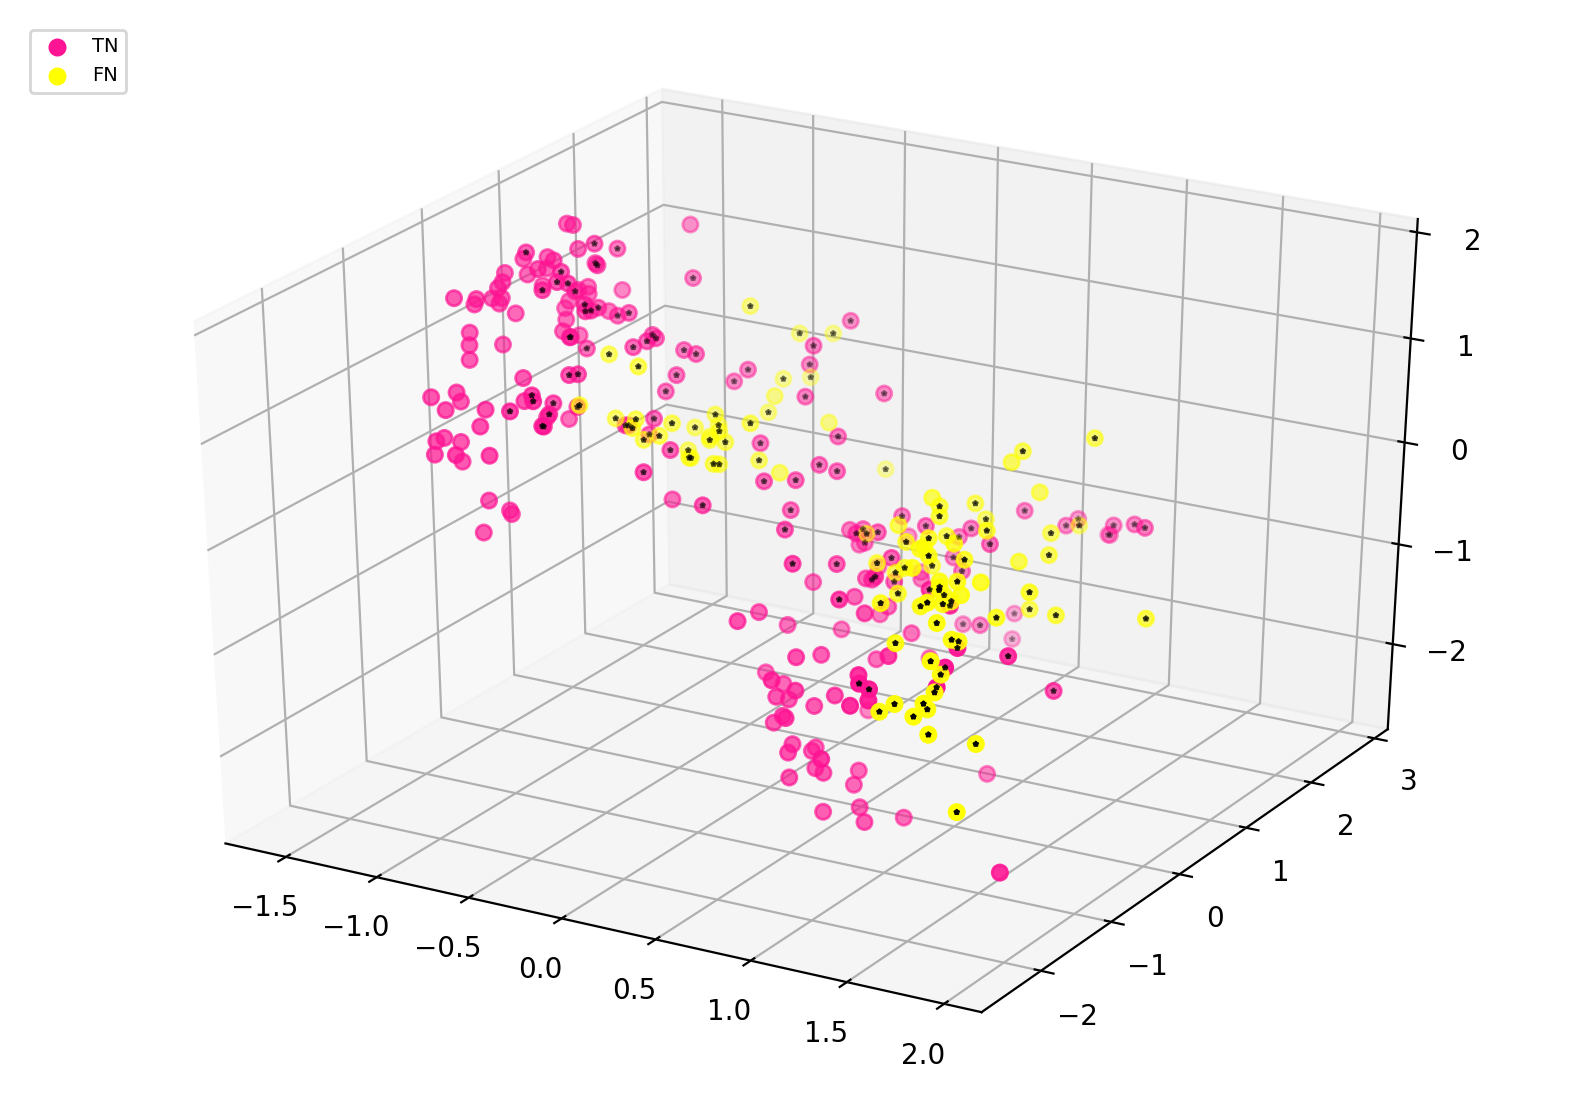

In [ ]:
#plot svm for train samples
plot_svm_output(x_train_B,output,model)

178


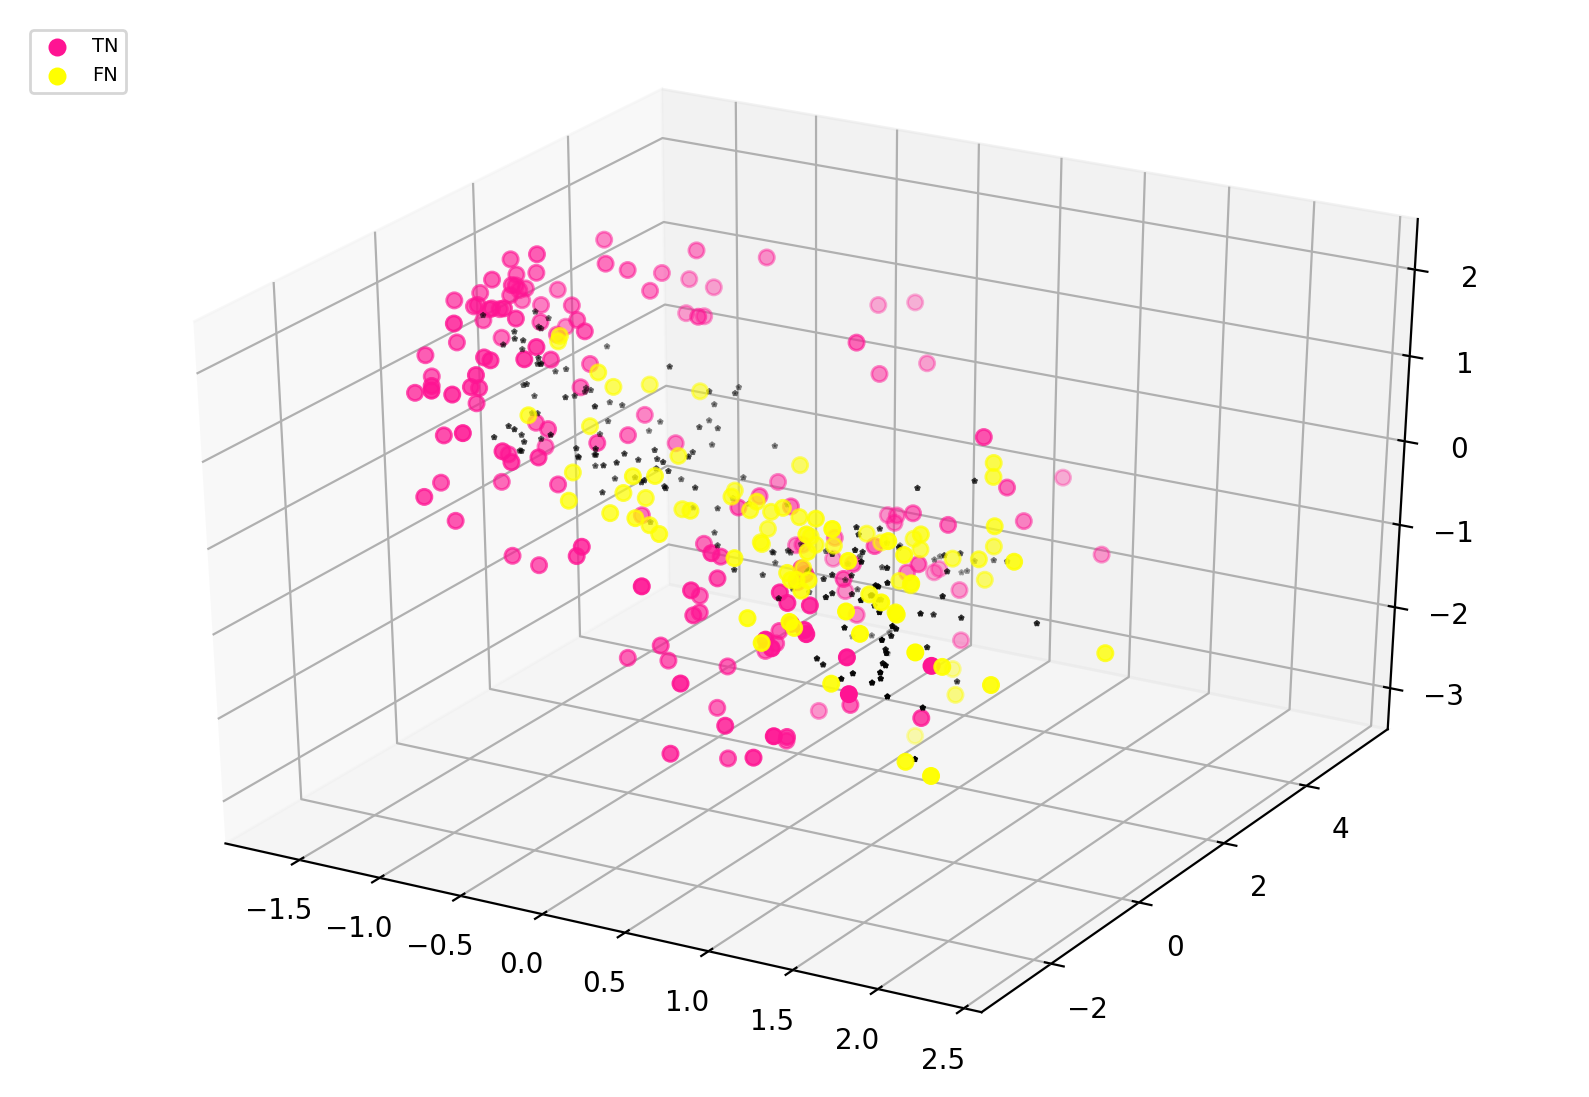

In [ ]:
#plot svm for test samples
plot_svm_output(x_test_B,output1,model)

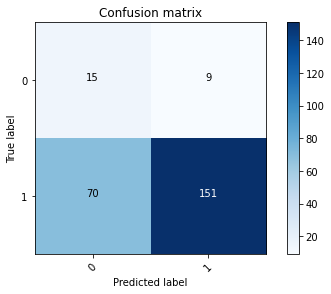

In [ ]:
#test samples
plot_confusion_matrix(y_test_B,output1,list(set(y_train_B))) 


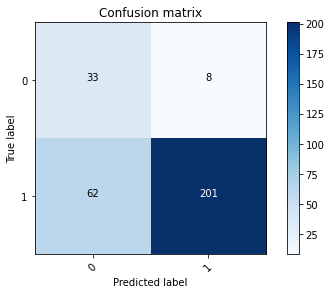

In [ ]:
#train samples
plot_confusion_matrix(y_train_B,output,list(set(y_train_B))) 


# train an SVM on balanced the B cluster’s samples (train-B) --> call it SVM-B

In [ ]:
# SVC_gridcv_search(x_train_B_balanced,y_train_B_balanced)

In [ ]:
# #output for B cluster imbalanced
# from sklearn import metrics

# weights =None
# model=final_model_svc(10,0.1,x_train_B_balanced,y_train_B_balanced,weights,"linear")
# output=model.predict(x_train_B_balanced)
# output1=model.predict(x_test_B_balanced)

# print (metrics.balanced_accuracy_score(y_train_B_balanced,output))
# print (metrics.balanced_accuracy_score(y_test_B_balanced,output1))




# # plot_confusion_matrix(y_train_B,output,list(set(y_train_B))) 


In [ ]:
# plot_confusion_matrix(y_test_B_balanced,output1,list(set(y_train_B_balanced))) 


# SECTION CLUSTER C

#### train an SVM on only the C cluster’s samples (train-C) --> call it SVM-C

In [ ]:
SVC_gridcv_search(x_train_C,y_train_C)

Best: 0.845736 using {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
0.826834 (0.037927) with: {'C': 1e-05, 'gamma': 1, 'kernel': 'rbf'}
0.821940 (0.028048) with: {'C': 1e-05, 'gamma': 0.1, 'kernel': 'rbf'}
0.807101 (0.032508) with: {'C': 1e-05, 'gamma': 0.01, 'kernel': 'rbf'}
0.803982 (0.033648) with: {'C': 1e-05, 'gamma': 0.001, 'kernel': 'rbf'}
0.803835 (0.033973) with: {'C': 1e-05, 'gamma': 0.0001, 'kernel': 'rbf'}
0.836601 (0.030181) with: {'C': 0.0001, 'gamma': 1, 'kernel': 'rbf'}
0.807104 (0.033018) with: {'C': 0.0001, 'gamma': 0.1, 'kernel': 'rbf'}
0.807101 (0.032508) with: {'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}
0.803946 (0.033571) with: {'C': 0.0001, 'gamma': 0.001, 'kernel': 'rbf'}
0.803957 (0.033977) with: {'C': 0.0001, 'gamma': 0.0001, 'kernel': 'rbf'}
0.828325 (0.031518) with: {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}
0.800749 (0.034672) with: {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
0.795726 (0.036407) with: {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
0.795356 (0.036397

In [ ]:
# show the results for each value of C with constant gamma value,it will help to choose the final C as not always the best..
#parameters from grid serach cv has a good result on test data -- please check the output for clear understanding

from sklearn import metrics

C=[10**-3, 10**-2,10**-1,10,10**0,10**2,10**3]
weight={0:1.5,1:1}
for i in C:
  model = SVC(C=i,gamma=0.1,class_weight=weight,kernel="rbf",decision_function_shape='ovo',probability=True)
  model.fit(x_train_C,y_train_C)
  # accuracy of train data 
  output1=model.predict(x_train_C)
  # accuracy of test data
  output=model.predict(x_test_C)
  #count the support vectors
  support_vectors = model.support_vectors_
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  # evaluate model
  scores = cross_val_score(model,x_train_C ,y_train_C , scoring='roc_auc', cv=cv, n_jobs=-1)
  # print (scores)
  # summarize performance
  print('Mean ROC AUC: %.3f' % mean(scores))
  print ("value of C : ",i)
  print ("number of support vector :",len(support_vectors))
  print ("test accuracy:",metrics.balanced_accuracy_score(y_test_C,output))
  print ("train accuracy :",metrics.balanced_accuracy_score(y_train_C,output1))

  print ("-----------------------------")

Mean ROC AUC: 0.825
value of C :  0.001
number of support vector : 992
test accuracy: 0.5
train accuracy : 0.5
-----------------------------
Mean ROC AUC: 0.825
value of C :  0.01
number of support vector : 992
test accuracy: 0.6796537386681207
train accuracy : 0.711297852474323
-----------------------------
Mean ROC AUC: 0.831
value of C :  0.1
number of support vector : 746
test accuracy: 0.7140617544816303
train accuracy : 0.7724556489262372
-----------------------------
Mean ROC AUC: 0.842
value of C :  10
number of support vector : 585
test accuracy: 0.7182945947788153
train accuracy : 0.7672268907563025
-----------------------------
Mean ROC AUC: 0.834
value of C :  1
number of support vector : 634
test accuracy: 0.7159770976756867
train accuracy : 0.7730158730158729
-----------------------------
Mean ROC AUC: 0.848
value of C :  100
number of support vector : 564
test accuracy: 0.7115670370117919
train accuracy : 0.7863056333644569
-----------------------------
Mean ROC AUC: 0.8

[0.84927536 0.84347826 0.84891304 0.82246377 0.85888889 0.81724392
 0.8577745  0.85335298 0.79108327 0.8183493  0.81268116 0.81050725
 0.80797101 0.8923913  0.88259259 0.80471629 0.81982314 0.91488578
 0.80545321 0.84340457 0.83731884 0.87753623 0.825      0.82898551
 0.83259259 0.8275608  0.88614591 0.86956522 0.80840088 0.80619013]
Mean ROC AUC: 0.838
0.775412387177093
0.713441483198146
595
595


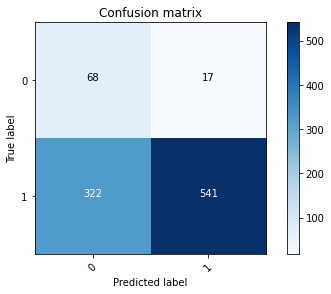

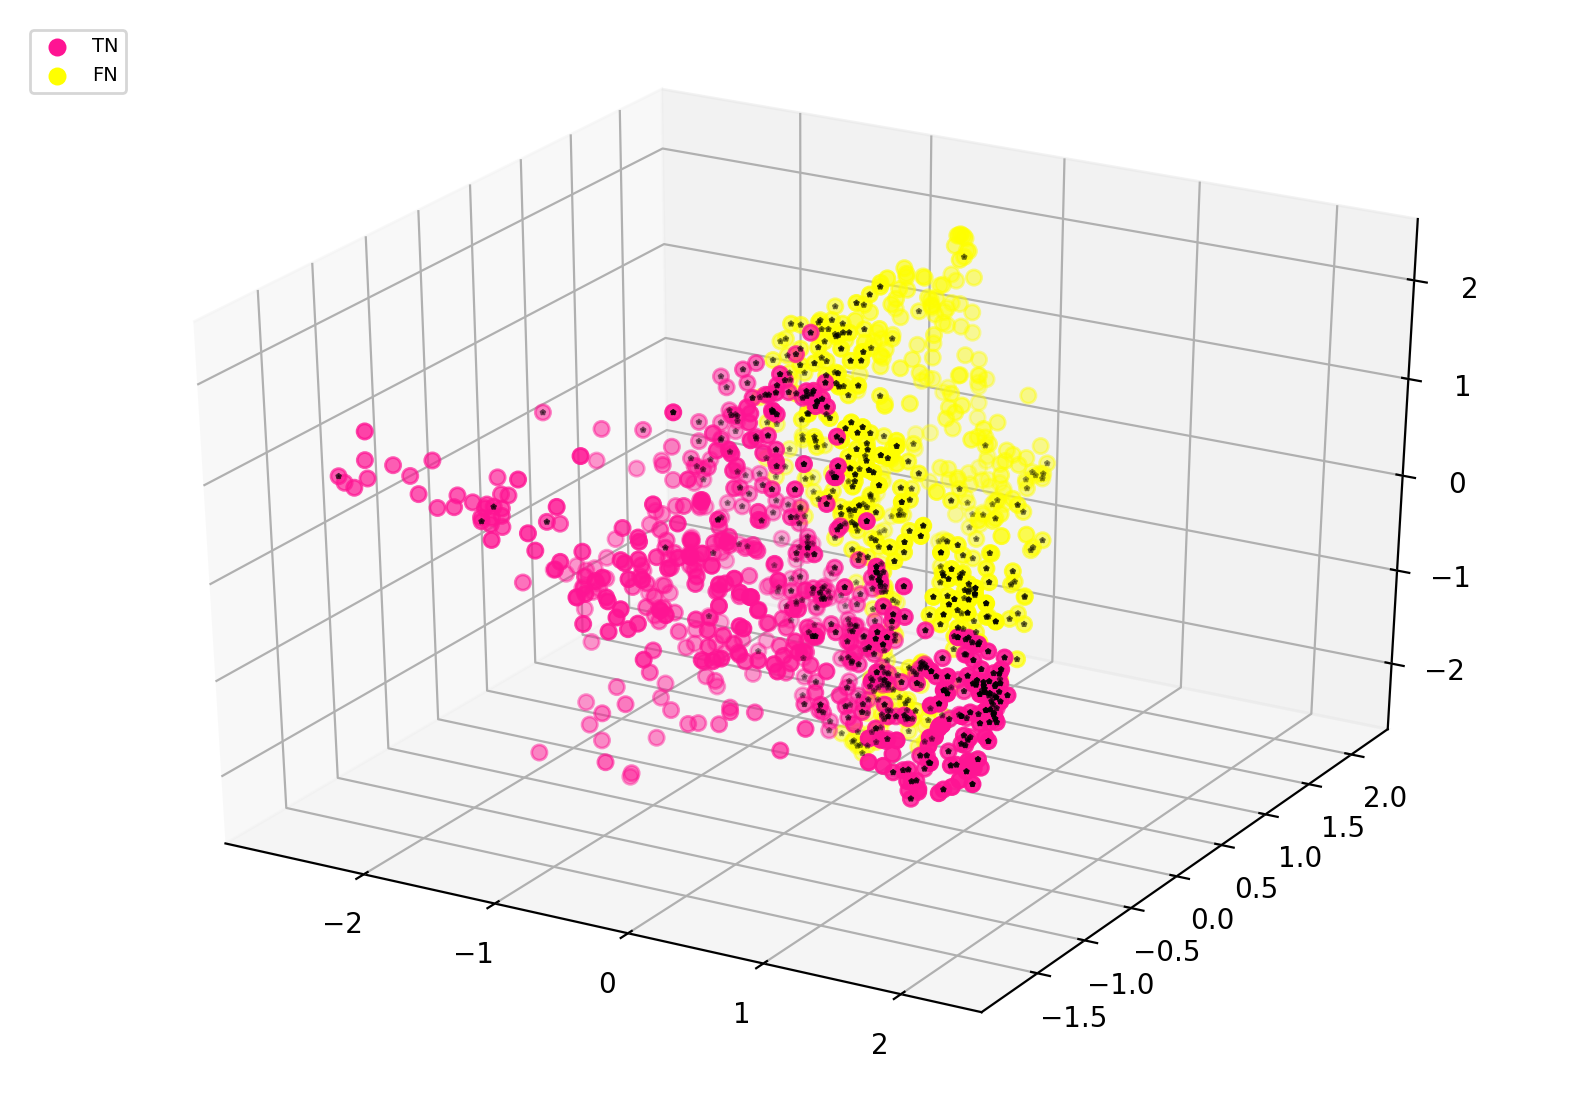

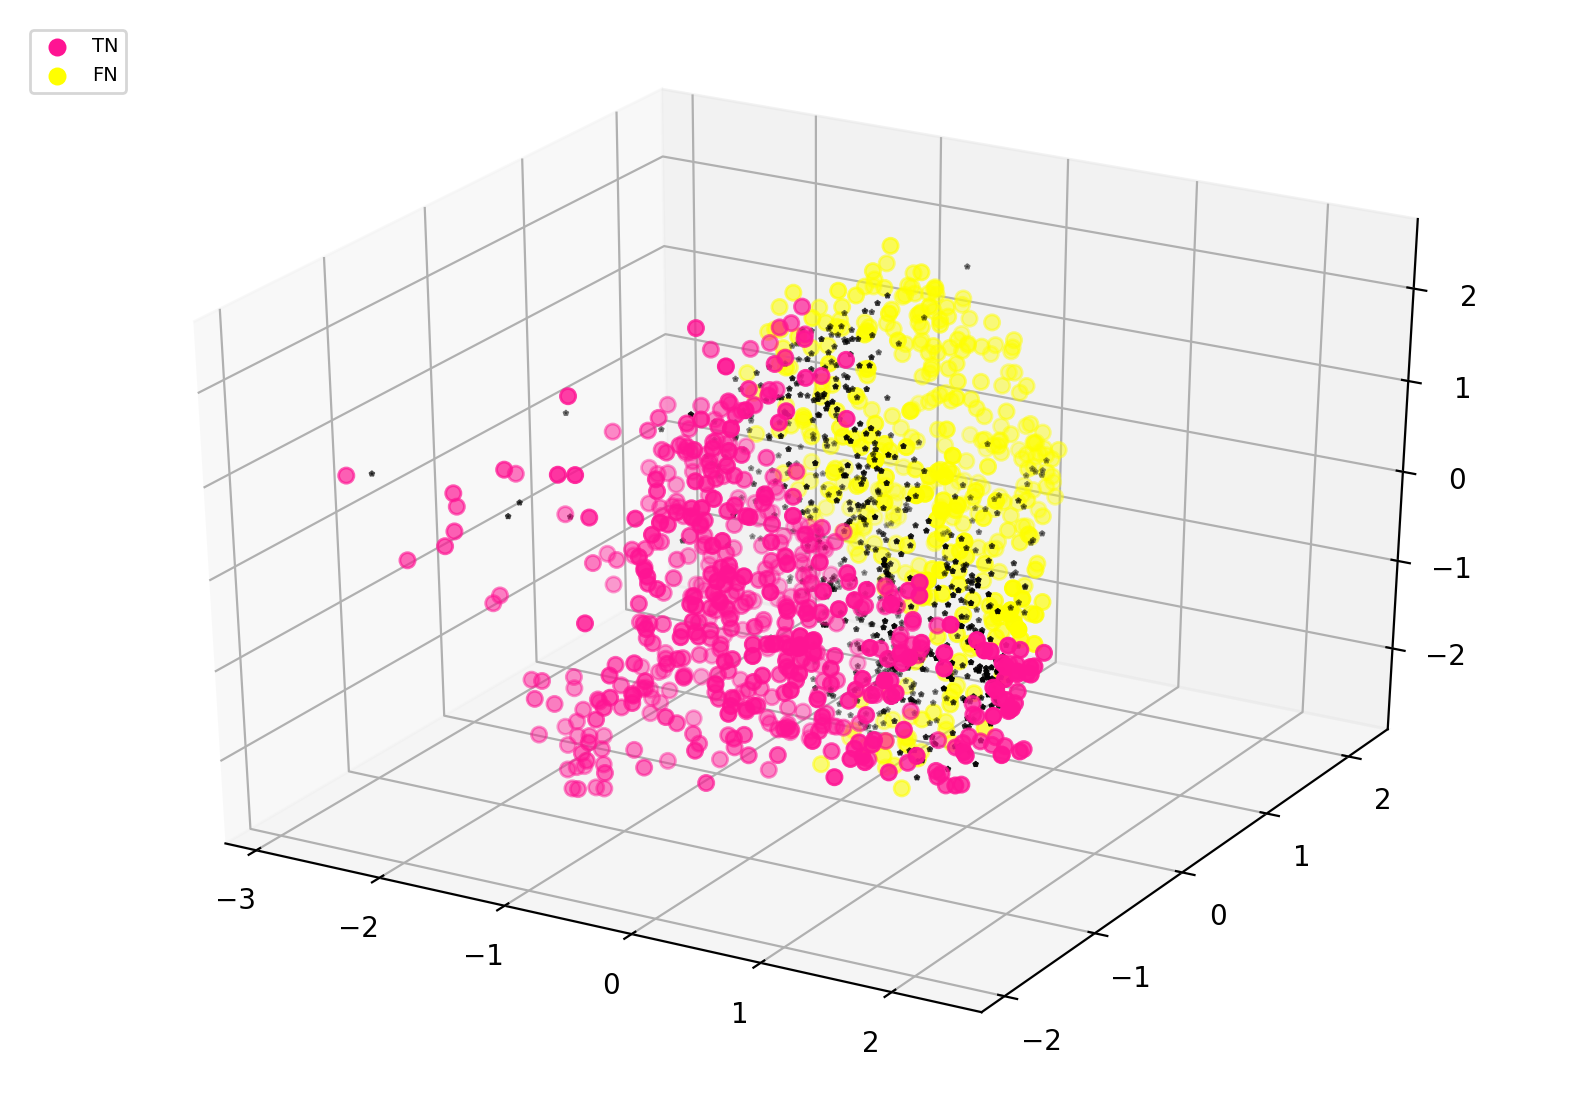

In [ ]:
#output for C cluster with C=10, and gamma=0.1
weights = {0:1, 1:1}
model=final_model_svc(10,0.1,x_train_C,y_train_C,weights,"rbf")
output=model.predict(x_train_C)
output1=model.predict(x_test_C)

print (metrics.balanced_accuracy_score(y_train_C,output))
print (metrics.balanced_accuracy_score(y_test_C,output1))
plot_confusion_matrix(y_test_C,output1,list(set(y_train_C))) 
plot_svm_output(x_train_C,output,model)
plot_svm_output(x_test_C,output1,model)



#### get information about the support vectors for cluster C

In [ ]:
support_vector_indices = model.support_
support_vectors_per_class = model.n_support_
support_vectors = model.support_vectors_
support_vectors=support_vectors.tolist()

In [ ]:
support_vector_indices

array([   2,   14,   73,   80,  101,  104,  105,  133,  134,  162,  197,
        201,  204,  205,  208,  213,  214,  215,  217,  218,  219,  220,
        225,  231,  232,  236,  242,  243,  244,  246,  247,  254,  257,
        259,  261,  262,  263,  268,  270,  272,  280,  285,  286,  299,
        300,  303,  340,  341,  342,  343,  345,  347,  352,  353,  359,
        360,  380,  399,  404,  406,  408,  409,  410,  411,  412,  413,
        414,  416,  417,  418,  419,  423,  424,  426,  432,  434,  435,
        436,  440,  441,  442,  443,  446,  448,  461,  463,  464,  467,
        470,  477,  480,  494,  497,  499,  503,  504,  509,  510,  513,
        514,  516,  522,  523,  524,  525,  530,  531,  532,  534,  537,
        538,  539,  541,  549,  552,  558,  559,  565,  571,  572,  573,
        574,  576,  577,  580,  581,  582,  586,  587,  589,  602,  605,
        606,  607,  615,  616,  620,  622,  624,  632,  633,  636,  637,
        652,  655,  656,  657,  663,  664,  666,  6

In [ ]:
x_train_C_=x_train_C.tolist()

In [ ]:
x_train_C_[0]

[-0.17748779404356646, -1.0607067776821084, 1.0394277973109896]

# Filter out the image names which are part of support vectors in cluster C final model




In [ ]:
c=0
support_vector_images=[]
sv_label=[]
original_label=[]
for i in support_vector_indices:
    support_vector_images.append(image_names_train_C[i])
    sv_label.append(output[i])
    original_label.append(y_train_C[i])

    if image_names_train_C[i].split("_")[0]=="TN":
    # print ("yes")
      c=c+1

In [ ]:
pd.DataFrame(support_vector_images).to_csv("images_names_support_vectors.csv")
pd.DataFrame(sv_label).to_csv("images_label_support_vectors.csv")
# pd.DataFrame(original_label).to_csv("images_original_label_support_vectors_588.csv")


In [ ]:
# plot_confusion_matrix(original_label,sv_label,list(set(y_train_C))) 
